# SCRATCH BOOK

In [26]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


def fetch_play_by_play_table(url):
    """
    Scrape the play-by-play table from the given NCAA game URL.

    Args:
        url (str): URL of the NCAA game play-by-play page.

    Returns:
        pd.DataFrame: DataFrame containing the play-by-play data.
    """
    # Set up Selenium WebDriver (update path to your ChromeDriver if needed)
    # service = Service(executable_path='chromedriver')  # Adjust 'chromedriver' path
    driver = webdriver.Chrome()

    try:
        # Load the page
        driver.get(url)

        # Wait for the page to load (adjust timeout if necessary)
        WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CLASS_NAME, 'play-by-play-period'))
        )

        # Parse the page content with BeautifulSoup
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        # Locate all periods
        period_divs = soup.find_all('div', {'class': 'play-by-play-period'})

        # Initialize an empty list to store all data
        all_data = []

        # Iterate through each period
        for period_div in period_divs:
            # Extract period header (e.g., "Start of 1st")
            period_header = period_div.find('h3').get_text(strip=True)

            # Find the table inside the period div
            pbp_table = period_div.find('div', {'class': 'play-by-play-period-table'}).find('table')

            # Extract rows from the table
            for row in pbp_table.find('tbody').find_all('tr'):
                cells = row.find_all('td')
                if len(cells) == 4:  # Ensure the row has all expected columns
                    time = cells[0].get_text(strip=True)
                    team = cells[1].get_text(strip=True)
                    description = cells[2].get_text(strip=True)
                    score = cells[3].get_text(strip=True)
                    all_data.append([period_header, time, team, description, score])

        # Create a DataFrame
        df = pd.DataFrame(all_data, columns=['Period', 'Time', 'Team', 'Description', 'Score'])
        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on error

    finally:
        # Close the Selenium WebDriver
        driver.quit()

# Example usage:
if __name__ == "__main__":
    url = "https://www.ncaa.com/game/6344953/play-by-play"
    play_by_play_df = fetch_play_by_play_table(url)
    if not play_by_play_df.empty:
        print(play_by_play_df.head())
    else:
        print("No data found.")

         Period   Time Team  \
0  Start of 1st  20:00        
1  Start of 1st  20:00        
2  Start of 1st  20:00        
3  Start of 1st  19:50        
4  Start of 1st  19:44        

                                         Description Score  
0  Faceoff Garvey, Cameron vs Fukakusa, Tyler won...        
1     Croix Kochendorfer at goalie for Robert Morris        
2                    Trent Burnham at goalie for RIT        
3  Shot by RIT Wilde, Matthew MISSED, save Kochen...        
4  Shot by ROBMOR Deelstra, Mitch MISSED, save Bu...        


In [27]:
# play_by_play_df.head(10)
# play_by_play_df.head(10)

### Data Cleaning of the Raw PbP table
-replace values in Period column to simple identifiers (1,2,3,OT)
- Convert Time column into Continuous_Time like in other workflows

In [28]:
# Rename to df for simplicity
df = play_by_play_df

#TO DO: replace values in Period column to simple identifiers (1,2,3,OT)
df['Period'] = df['Period'].replace({
    'Start of 1st': '1',
    'Start of 2nd': '2',
    'Start of 3rd': '3',
    'Start of OT': 'OT'
})

# To DO : Replace the values in the Time column - convert to seconds since the beginning of the game
# If period is 1, 20:00 is now 0 and 19:59 is 1, so on and so forth
# If period is 2, 20:00 is now 1200 and 19:59 is 1201, so on and so forth

# Convert string time to continuous time
def convert_to_continuous_time(row):
    """
    Converts period-based time to a continuous format (0-65 minutes).
    """
    period_offsets = {'1': 0, '2': 20, '3': 40, 'OT': 60}
    minutes, seconds = map(int, row['Time'].split(':'))
    # Subtract the minutes : seconds from 20:00 to get time elapsed
    elapsed_time = (20 - minutes) * 60 + - seconds
    offset = period_offsets.get(row['Period'], 0) * 60
    return offset + elapsed_time

df['Time'] = df.apply(convert_to_continuous_time, axis=1)


# def convert_time_to_seconds(time_str, period):
#     if period == '1' or period == '2':
#         minutes, seconds = map(int, time_str.split(':'))
#         total_seconds = (20 - minutes) * 60 + seconds
#     elif period == '3':
#         minutes, seconds = map(int, time_str.split(':'))
#         total_seconds = (20 - minutes) * 60 + seconds
#     elif period == 'OT':
#         minutes, seconds = map(int, time_str.split(':'))
#         total_seconds = (5 - minutes) * 60 + seconds
#     else:
#         total_seconds = None  # Handle unexpected periods
#     return total_seconds
# df['Time'] = df.apply(lambda x: convert_time_to_seconds(x['Time'], x['Period']), axis=1)

df.tail()

# def convert_time_to_seconds(time_str, period):
#     if period == '1' or period == '2':
#         minutes, seconds = map(int, time_str.split(':'))
#         total_seconds = (20 - minutes) * 60 + seconds
#     elif period == '3':
#         minutes, seconds = map(int, time_str.split(':'))
#         total_seconds = (20 - minutes) * 60 + seconds
#     elif period == 'OT':
#         minutes, seconds = map(int, time_str.split(':'))
#         total_seconds = (5 - minutes) * 60 + seconds
#     else:
#         total_seconds = None  # Handle unexpected periods
#     return total_seconds
# df['Time'] = df.apply(lambda x: convert_time_to_seconds(x['Time'], x['Period']), axis=1)

df.tail()


,Period,Time,Team,Description,Score
202,3,3562,,"Shot by ROBMOR Deelstra, Mitch MISSED, save Bu...",
203,3,3566,,"Shot by ROBMOR Wilson, Trent MISSED, save Burn...",
204,3,3568,,End power play for ROBMOR.,
205,3,3596,,"Shot by RIT Mahan, Tyler WIDE.",
206,3,3598,,"Shot by RIT Isabelle, Simon WIDE.",


In [29]:
# df.head(20)

### Parse the Description Column into structured data

In [30]:
## V 2.2

import re
import pandas as pd

def parse_description(description):
    """
    Parse a single play-by-play description into structured fields.

    Args:
        description (str): The play-by-play description.

    Returns:
        dict: Parsed fields capturing the important pieces of data.
    """
    # Normalize for easier detection
    desc_lower = description.lower().strip()

    # Initialize the parse dictionary with a default fallback
    parsed = {
        "Event_type": "Other",
        "Primary_player": None,
        "Primary_team": None,
        "Secondary_player": None,
        "Secondary_team": None,
        "Outcome": None,            # e.g. "won", "blocked", "missed", "wide", "saved", etc.
        "Assist_players": None,     # for goals with multiple assists
        "Penalty_type": None,       # e.g., "Slashing," "Roughing"
        "Penalty_duration": None,   # e.g., 2,4,5,10
        "Goaltender_in": None,      # e.g. "Logan Stein"
        "Goaltender_team": None,
    }

    # --- 1) Faceoff ---
    if "faceoff" in desc_lower:
        parsed["Event_type"] = "Faceoff"
        # Example: "Faceoff Shoudy, Tiernan vs Draper, Kienan won by MICHST."
        faceoff_pattern = (
            r"Faceoff\s+([A-Za-zÀ-ÖØ-öø-ÿ\'\.\- ]+, [A-Za-zÀ-ÖØ-öø-ÿ\'\.\- ]+)"  # group(1): winner
            r"\s+vs\s+([A-Za-zÀ-ÖØ-öø-ÿ\'\.\- ]+, [A-Za-zÀ-ÖØ-öø-ÿ\'\.\- ]+)"    # group(2): loser
            r"\s+won by\s+([A-Za-zÀ-ÖØ-öø-ÿ\'\.\- ]+)\.?"                       # group(3): winning team
        )
        match = re.search(faceoff_pattern, description)
        if match:
            parsed["Primary_player"] = match.group(1).strip()
            parsed["Secondary_player"] = match.group(2).strip()
            parsed["Primary_team"] = match.group(3).strip()
            parsed["Outcome"] = "won"
        return parsed

    # --- 2) Goal ---
    #    We only interpret lines containing "Goal by" (to avoid confusion with "goalie")
    if re.search(r"\bgoal by\b", desc_lower):
        parsed["Event_type"] = "Goal"
        # Find "Goal by <player>"
        goal_scorer_pattern = (
            r"Goal by\s+([A-Za-zÀ-ÖØ-öø-ÿ\'\.\- ]+, [A-Za-zÀ-ÖØ-öø-ÿ\'\.\- ]+)"
        )
        gm = re.search(goal_scorer_pattern, description)
        if gm:
            parsed["Primary_player"] = gm.group(1).strip()

        # Extract the assist section if present: "Assist by: <player1, player2...>"
        assist_pattern = r"Assist by:\s*(.*?)(?=On ice for|$)"
        am = re.search(assist_pattern, description)
        if am:
            assist_text = am.group(1).strip()
            assist_names = re.findall(
                r"[A-Za-zÀ-ÖØ-öø-ÿ\'\.\- ]+, [A-Za-zÀ-ÖØ-öø-ÿ\'\.\- ]+", assist_text
            )
            if assist_names:
                parsed["Assist_players"] = [an.strip() for an in assist_names]

        return parsed

    # --- 3) Penalty ---
    #    Enhanced penalty parsing to handle lines like:
    #      "Penalty on Calafiore, Anthony MAINE 2 minutes for Slashing."
    #      "Penalty on Mitton, Ross MAINE minutes for Duration:10"
    #    etc.
    if desc_lower.startswith("penalty on"):
        parsed["Event_type"] = "Penalty"

        # Try to capture the normal pattern, e.g.
        # "Penalty on Last, First TEAM 2 minutes for Slashing."
        # group(1) = "Last, First"
        # group(2) = "TEAM"
        # group(3) = numeric duration
        # group(4) = penalty type
        penalty_pattern = re.compile(
            r"Penalty on\s+"
            r"([A-Za-zÀ-ÖØ-öø-ÿ'\.\- ]+,\s*[A-Za-zÀ-ÖØ-öø-ÿ'\.\- ]+)\s+"   # (1) "Last, First"
            r"([A-Za-zÀ-ÖØ-öø-ÿ'\.\- ]+)\s+"                                # (2) "TEAM"
            r"(\d+)\s+minutes?\s+for\s+(.+)",                               # (3) "2", (4) "Slashing."
            flags=re.IGNORECASE
        )
        pm = penalty_pattern.search(description)
        if pm:
            parsed["Primary_player"] = pm.group(1).strip()
            parsed["Primary_team"] = pm.group(2).strip()
            parsed["Penalty_duration"] = pm.group(3).strip()
            # Clean up trailing punctuation from penalty type
            ptype = pm.group(4).rstrip(" .").strip()
            parsed["Penalty_type"] = ptype
            return parsed

        # If the above pattern fails, check for a fallback pattern, e.g.
        # "Penalty on Mitton, Ross MAINE minutes for Duration:10" 
        # (No explicit numeric before 'minutes', but the duration is embedded.)
        fallback_pattern = re.compile(
            r"Penalty on\s+"
            r"([A-Za-zÀ-ÖØ-öø-ÿ'\.\- ]+,\s*[A-Za-zÀ-ÖØ-öø-ÿ'\.\- ]+)\s+"  # (1) "Last, First"
            r"([A-Za-zÀ-ÖØ-öø-ÿ'\.\- ]+)\s+"                               # (2) "TEAM"
            r"minutes?\s+for\s+(.*)",                                      # (3) "Duration:10" or "some penalty"
            flags=re.IGNORECASE
        )
        pm2 = fallback_pattern.search(description)
        if pm2:
            parsed["Primary_player"] = pm2.group(1).strip()
            parsed["Primary_team"] = pm2.group(2).strip()
            remainder = pm2.group(3).strip()

            # Check if there's "Duration:XX"
            dur_match = re.search(r"Duration:(\d+)", remainder, flags=re.IGNORECASE)
            if dur_match:
                parsed["Penalty_duration"] = dur_match.group(1).strip()
                # The penalty type could be after that text,
                # e.g. "Duration:10 for Misconduct"
                # so let's isolate that if it exists:
                split_text = remainder.split(dur_match.group(0), 1)
                if len(split_text) > 1:
                    # anything after "Duration:XX" is presumably penalty type
                    ptype = split_text[1].strip(" .-:")
                    parsed["Penalty_type"] = ptype
            else:
                # No numeric duration found, so just treat all of remainder as penalty_type
                parsed["Penalty_type"] = remainder
            return parsed

        # If we still haven't matched, we leave the penalty info mostly blank
        # but keep Event_type as "Penalty"
        return parsed

    # --- 4) Goaltender Change ---
    if "at goalie for" in desc_lower:
        parsed["Event_type"] = "Goaltender Change"
        goalie_pattern = r"(.+?)\s+at goalie for\s+([A-Za-zÀ-ÖØ-öø-ÿ\'\.\- ]+)\.?"
        gm = re.search(goalie_pattern, description, flags=re.IGNORECASE)
        if gm:
            parsed["Goaltender_in"] = gm.group(1).strip()
            parsed["Goaltender_team"] = gm.group(2).strip()
        return parsed

    # --- 5) Shot ---
    if desc_lower.startswith("shot by"):
        parsed["Event_type"] = "Shot"
        shot_team_pattern = r"^Shot by\s+([A-Za-z0-9.\-]+)\s+(.*)$"
        m1 = re.search(shot_team_pattern, description)
        if m1:
            possible_team = m1.group(1).strip()
            remainder = m1.group(2).strip()
            parsed["Primary_team"] = possible_team

            block_re = re.search(r"\bBLOCKED by\b\s+(.+)", remainder, flags=re.IGNORECASE)
            miss_re  = re.search(r"\bMISSED\b(.*)", remainder, flags=re.IGNORECASE)
            wide_re  = re.search(r"\bWIDE\b(.*)", remainder, flags=re.IGNORECASE)
            save_re  = re.search(r"\bsave\b\s+(.+)", remainder, flags=re.IGNORECASE)

            if block_re:
                parsed["Outcome"] = "Blocked"
                parsed["Secondary_player"] = block_re.group(1).strip()
                shooter_part = remainder.split("BLOCKED by", 1)[0].strip()
            elif miss_re:
                parsed["Outcome"] = "Missed"
                shooter_part = remainder.split("MISSED", 1)[0].rstrip(", ").strip()
            elif wide_re:
                parsed["Outcome"] = "Wide"
                shooter_part = remainder.split("WIDE", 1)[0].strip()
            elif save_re:
                parsed["Outcome"] = "Saved"
                parsed["Secondary_player"] = save_re.group(1).strip()
                shooter_part = remainder.split("save", 1)[0].rstrip(", ").strip()
            else:
                # No recognized outcome, store entire remainder as shooter part
                shooter_part = remainder

            # Try to pick out "Last, First" from shooter_part
            name_match = re.search(r"([A-Za-zÀ-ÖØ-öø-ÿ\'\.\- ]+, [A-Za-zÀ-ÖØ-öø-ÿ\'\.\- ]+)$", shooter_part)
            if name_match:
                parsed["Primary_player"] = name_match.group(1).strip()
            else:
                parsed["Primary_player"] = shooter_part.strip()

        return parsed

    # --- 6) Start/End Power Play ---
    if "start power play" in desc_lower:
        parsed["Event_type"] = "Start Power Play"
        sp = re.search(r"Start power play for\s+([A-Za-zÀ-ÖØ-öø-ÿ\'\.\- ]+)", description, re.IGNORECASE)
        if sp:
            parsed["Primary_team"] = sp.group(1).strip()
        return parsed

    if "end power play" in desc_lower:
        parsed["Event_type"] = "End Power Play"
        ep = re.search(r"End power play for\s+([A-Za-zÀ-ÖØ-öø-ÿ\'\.\- ]+)", description, re.IGNORECASE)
        if ep:
            parsed["Primary_team"] = ep.group(1).strip()
        return parsed

    # If none of the above matched, we leave it as "Other"
    return parsed


def transform_pbp_descriptions(descriptions):
    """
    Transform a list of play-by-play descriptions into a structured DataFrame.

    Args:
        descriptions (list): List of play-by-play descriptions.

    Returns:
        pd.DataFrame: Transformed DataFrame with parsed fields.
    """
    parsed_data = [parse_description(desc) for desc in descriptions]
    return pd.DataFrame(parsed_data)


def clean_player_name(name):
    """
    Converts a name from "Last, First" to "First Last", handling punctuation.
    Example: "Hughes, T.J." -> "T.J. Hughes"
    """
    if not name:
        return None
    parts = [p.strip() for p in name.split(',')]
    if len(parts) == 2:
        last, first = parts
        return f"{first} {last}".strip()
    return name



# Example usage / integration:
if __name__ == "__main__":
    # # Suppose your df has a "Description" column
    # df = pd.DataFrame({
    #     "Description": [
    #         "Faceoff Shoudy, Tiernan vs Draper, Kienan won by MICHST.",
    #         "Trey Augustine at goalie for Michigan St.",
    #         "Shot by MICHST Å trbãk, Maxim BLOCKED by Estapa, Mark.",
    #         "Penalty on Draper, Kienan MICH for Slashing.",
    #         "Goal by Dorwart, Karsen (EVEN STRENGTH) Assist by: Larson, Joey, On ice for MICH: ...",
    #         "Start power play for MICHST.",
    #         "End power play for MICHST."
    #     ]
    # })

    # Parse
    parsed_df = transform_pbp_descriptions(df["Description"])

    # Combine with original
    df = pd.concat([df, parsed_df], axis=1)

    # Clean up name fields
    name_cols = ["Primary_player", "Secondary_player", "Goaltender_in"]
    for col in name_cols:
        df[col] = df[col].apply(clean_player_name)

    # If you want to clean up lists of assists:
    def clean_assist_list(assist_list):
        if not assist_list:
            return None
        return [clean_player_name(x) for x in assist_list]

    df["Assist_players"] = df["Assist_players"].apply(clean_assist_list)

    print(df)


    Period  Time Team                                        Description  \
0        1     0       Faceoff Garvey, Cameron vs Fukakusa, Tyler won...   
1        1     0          Croix Kochendorfer at goalie for Robert Morris   
2        1     0                         Trent Burnham at goalie for RIT   
3        1    10       Shot by RIT Wilde, Matthew MISSED, save Kochen...   
4        1    16       Shot by ROBMOR Deelstra, Mitch MISSED, save Bu...   
..     ...   ...  ...                                                ...   
202      3  3562       Shot by ROBMOR Deelstra, Mitch MISSED, save Bu...   
203      3  3566       Shot by ROBMOR Wilson, Trent MISSED, save Burn...   
204      3  3568                              End power play for ROBMOR.   
205      3  3596                          Shot by RIT Mahan, Tyler WIDE.   
206      3  3598                       Shot by RIT Isabelle, Simon WIDE.   

    Score         Event_type  Primary_player Primary_team Secondary_player  \
0        

In [31]:
df.head(20)

## Check out Event_type Goal
# df[df['Event_type'] == 'Penalty'].head(20)
# # Check out Event_type Shot
# df[df['Event_type'] == 'Shot'].head(20)

,Period,Time,Team,Description,Score,Event_type,Primary_player,Primary_team,Secondary_player,Secondary_team,Outcome,Assist_players,Penalty_type,Penalty_duration,Goaltender_in,Goaltender_team
0,1,0,,"Faceoff Garvey, Cameron vs Fukakusa, Tyler won...",,Faceoff,Cameron Garvey,ROBMOR.,Tyler Fukakusa,None,won,None,None,None,None,None
1,1,0,,Croix Kochendorfer at goalie for Robert Morris,,Goaltender Change,None,None,None,None,None,None,None,None,Croix Kochendorfer,Robert Morris
2,1,0,,Trent Burnham at goalie for RIT,,Goaltender Change,None,None,None,None,None,None,None,None,Trent Burnham,RIT
3,1,10,,"Shot by RIT Wilde, Matthew MISSED, save Kochen...",,Shot,Matthew Wilde,RIT,None,None,Missed,None,None,None,None,None
4,1,16,,"Shot by ROBMOR Deelstra, Mitch MISSED, save Bu...",,Shot,Mitch Deelstra,ROBMOR,None,None,Missed,None,None,None,None,None
5,1,19,,"Faceoff Fukakusa, Tyler vs Garvey, Cameron won...",,Faceoff,Tyler Fukakusa,RIT.,Cameron Garvey,None,won,None,None,None,None,None
6,1,26,,"Faceoff Wilson, Trent vs Fukakusa, Tyler won b...",,Faceoff,Trent Wilson,ROBMOR.,Tyler Fukakusa,None,won,None,None,None,None,None
7,1,84,,"Faceoff Isabelle, Simon vs Johnson, Patrick wo...",,Faceoff,Simon Isabelle,RIT.,Patrick Johnson,None,won,None,None,None,None,None
8,1,107,,"Faceoff Isabelle, Simon vs Johnson, Patrick wo...",,Faceoff,Simon Isabelle,RIT.,Patrick Johnson,None,won,None,None,None,None,None
9,1,143,,"Faceoff Krotiris, George vs Jacques, Philippe ...",,Faceoff,George Krotiris,ROBMOR.,Philippe Jacques,None,won,None,None,None,None,None


In [32]:
# df.tail()
# df.head(20)

In [33]:
data = df.copy()

# Step 1: Normalize data - Treat "Goal" events as successful "Shot" events
data['Event_type'] = data['Event_type'].replace('Goal', 'Shot')

# Step 2: Group data into time intervals (e.g., every 60 seconds = 1 minute)
data['Time Interval (min)'] = (data['Time'] // 60)  # Group by minute

# Step 3: Count shots for each team over time
shot_counts = data[data['Event_type'] == 'Shot'].groupby(['Time Interval (min)', 'Primary_team']).size().reset_index(name='Shots')

# Step 4: Cumulative shots over time
shot_counts['Cumulative Shots'] = shot_counts.groupby('Primary_team')['Shots'].cumsum()

# Step 5: Pivot data for visualization
cumulative_shots_pivot = shot_counts.pivot(index='Time Interval (min)', columns='Primary_team', values='Cumulative Shots').fillna(0)

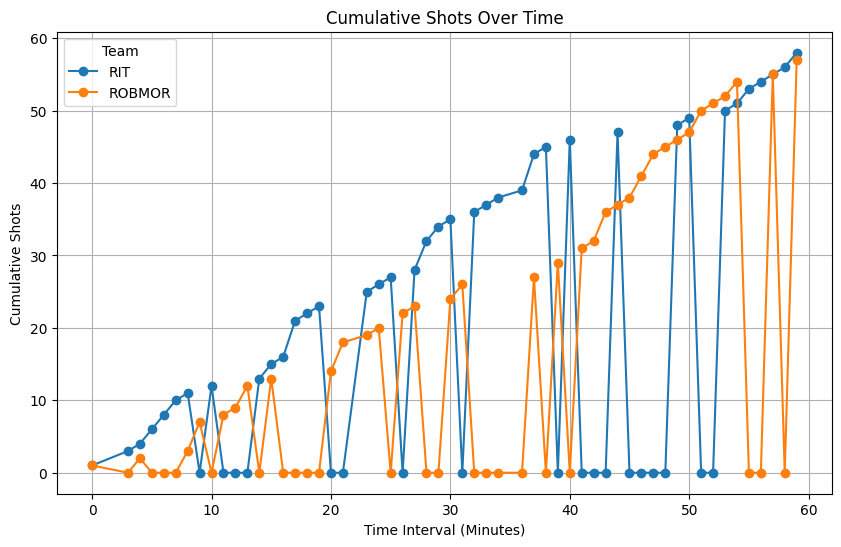

In [34]:
# Plot cumulative shots for each team over time
plt.figure(figsize=(10, 6))
for team in cumulative_shots_pivot.columns:
    plt.plot(cumulative_shots_pivot.index, cumulative_shots_pivot[team], label=team, marker='o')

plt.title('Cumulative Shots Over Time')
plt.xlabel('Time Interval (Minutes)')
plt.ylabel('Cumulative Shots')
plt.legend(title='Team')
plt.grid(True)
plt.show()


c:\Users\jbanc\anaconda3\envs\data_viz\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\jbanc\anaconda3\envs\data_viz\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


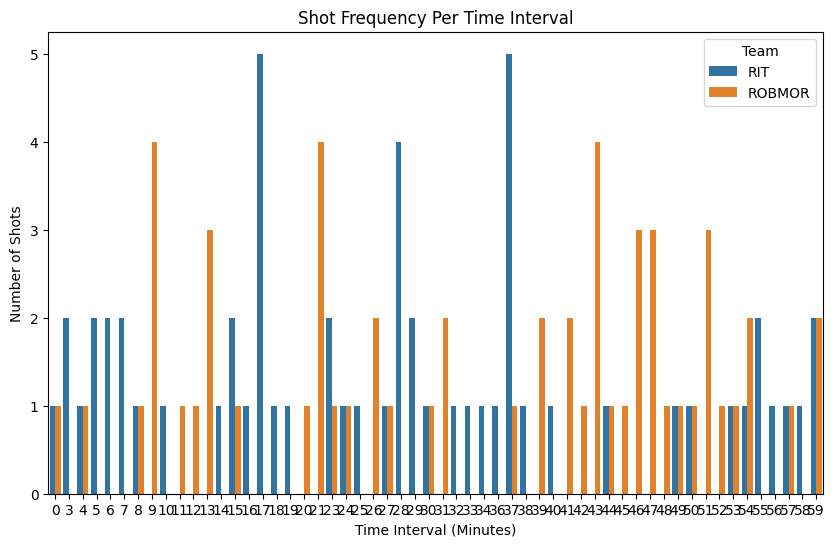

In [35]:
# Group data for bar chart
shot_frequency = data[data['Event_type'] == 'Shot'].groupby(['Time Interval (min)', 'Primary_team']).size().reset_index(name='Shots')

# Bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Time Interval (min)', y='Shots', hue='Primary_team', data=shot_frequency)
plt.title('Shot Frequency Per Time Interval')
plt.xlabel('Time Interval (Minutes)')
plt.ylabel('Number of Shots')
plt.legend(title='Team')
plt.show()


In [36]:
### Create a list of every value in the description column
raw_list = df['Description'].unique()
raw_list


array(['Faceoff Garvey, Cameron vs Fukakusa, Tyler won by ROBMOR.',
       'Croix Kochendorfer at goalie for Robert Morris',
       'Trent Burnham at goalie for RIT',
       'Shot by RIT Wilde, Matthew MISSED, save Kochendorfer, Croix.',
       'Shot by ROBMOR Deelstra, Mitch MISSED, save Burnham, Trent.',
       'Faceoff Fukakusa, Tyler vs Garvey, Cameron won by RIT.',
       'Faceoff Wilson, Trent vs Fukakusa, Tyler won by ROBMOR.',
       'Faceoff Isabelle, Simon vs Johnson, Patrick won by RIT.',
       'Faceoff Krotiris, George vs Jacques, Philippe won by ROBMOR.',
       'Faceoff Cobetto-roy, Mathieu vs Garvey, Cameron won by RIT.',
       'Shot by RIT Fukakusa, Tyler WIDE.',
       'Goal by Stewart, Crossley (EVEN STRENGTH, FIRST GOAL) Assist by: Fukakusa, Tyler, On ice for ROBMOR: Michael Craig; Walter Zacher; Gabriel Lunn; Cameron Garvey; Croix Kochendorfer; Mitch Deelstra RIT: Dimitri Mikrogiannakis; Crossley Stewart; Xavier Lapointe; Matthew Wilde; Tristan Allen; Christian Ca

In [37]:
breakpoint


<function breakpoint>

In [38]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd

from selenium import webdriver
from bs4 import BeautifulSoup

# url = 'https://www.ncaa.com/game/6344804/play-by-play'

# # Set up Selenium WebDriver
driver = webdriver.Chrome()  # Make sure you have the ChromeDriver installed
# # driver.get(url)

def fetch_play_by_play_table(url):
    """
    Scrape the play-by-play table from the given NCAA game URL.

    Args:
        url (str): URL of the NCAA game play-by-play page.

    Returns:
        pd.DataFrame: DataFrame containing the play-by-play data.
    """
    # Set up Selenium WebDriver (adjust the path to your ChromeDriver)
    # service = Service(executable_path='chromedriver')  # Update 'chromedriver' path if necessary
    # driver = webdriver.Chrome(service=service)

    try:
        # Load the page
        driver.get(url)

        # Wait for the table to load (adjust timeout if needed)
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'gamecenter-tab-play-by-play'))
        )

        # Get page source and parse it with BeautifulSoup
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        # Find the play-by-play table
        pbp_table = soup.find('table', {'class': 'play-by-play-period-table'})

        # Check if the table was found
        if pbp_table is None:
            raise ValueError("Play-by-play table not found on the page.")

        # Extract rows from the table
        data = []
        for row in pbp_table.find_all('tr'):
            cells = row.find_all('td')
            if len(cells) > 1:  # Skip header rows
                time = cells[0].get_text(strip=True)
                team = cells[1].get_text(strip=True)
                description = cells[2].get_text(strip=True)
                data.append([time, team, description])

        # Create a DataFrame
        df = pd.DataFrame(data, columns=['Time', 'Team', 'Description'])
        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on error

    finally:
        # Close the Selenium WebDriver
        driver.quit()

# Example usage:
if __name__ == "__main__":
    url = "https://www.ncaa.com/game/6344804/play-by-play"
    play_by_play_df = fetch_play_by_play_table(url)
    if not play_by_play_df.empty:
        print(play_by_play_df.head())
    else:
        print("No data found.")


An error occurred: Play-by-play table not found on the page.
No data found.


In [39]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = 'https://www.ncaa.com/game/6344804/play-by-play'
response = requests.get(url)
if response.status_code == 200:
    page_content = response.text
else:
    raise Exception(f"Failed to retrieve the webpage. Status code: {response.status_code}")

soup = BeautifulSoup(page_content, 'html.parser')

# print the soup to debug
print(soup.prettify())

pbp_table = soup.find('table', {'class': 'gamecenter-tab-play-by-play'})

data = []
for row in pbp_table.find_all('tr'):
    cells = row.find_all('td')
    if len(cells) > 1:  # Ensure it's not a header row
        time = cells[0].get_text(strip=True)
        team = cells[1].get_text(strip=True)
        description = cells[2].get_text(strip=True)
        data.append([time, team, description])

df = pd.DataFrame(data, columns=['Time', 'Team', 'Description'])

df.head()


<!DOCTYPE html>
<html dir="ltr" lang="en" prefix="og: https://ogp.me/ns#">
 <head>
  <meta charset="utf-8"/>
  <script type="text/javascript">
   (window.NREUM||(NREUM={})).init={ajax:{deny_list:["bam.nr-data.net"]}};(window.NREUM||(NREUM={})).loader_config={xpid:"UgYCUlJACQMDVVZVDgIF",licenseKey:"b4c08c65aa",applicationID:"103177932"};;/*! For license information please see nr-loader-full-1.278.3.min.js.LICENSE.txt */
(()=>{var e,t,r={8122:(e,t,r)=>{"use strict";r.d(t,{a:()=>i});var n=r(944);function i(e,t){try{if(!e||"object"!=typeof e)return(0,n.R)(3);if(!t||"object"!=typeof t)return(0,n.R)(4);const r=Object.create(Object.getPrototypeOf(t),Object.getOwnPropertyDescriptors(t)),o=0===Object.keys(r).length?e:r;for(let a in o)if(void 0!==e[a])try{if(null===e[a]){r[a]=null;continue}Array.isArray(e[a])&&Array.isArray(t[a])?r[a]=Array.from(new Set([...e[a],...t[a]])):"object"==typeof e[a]&&"object"==typeof t[a]?r[a]=i(e[a],t[a]):r[a]=e[a]}catch(e){(0,n.R)(1,e)}return r}catch(e){(0,n.R)(2,e

AttributeError: 'NoneType' object has no attribute 'find_all'

In [8]:
from selenium import webdriver
from bs4 import BeautifulSoup

# Set up Selenium WebDriver
driver = webdriver.Chrome()  # Make sure you have the ChromeDriver installed
driver.get(url)

# Let the page load completely
soup = BeautifulSoup(driver.page_source, 'html.parser')
driver.quit()

# Continue processing the soup object as before
pbp_table = soup.find('table', {'class': 'gamecenter-tab-play-by-play'})



In [ ]:
print(pbp_table)

In [ ]:
# from bs4 import BeautifulSoup
# import pandas as pd

# async def get_url_response(url):
#     """
#     Fetch and render the HTML content from the given URL.
#     """
#     session = AsyncHTMLSession()
#     response = await session.get(url)
#     await response.html.arender()  # Asynchronously render JavaScript
#     return response.html.html

# def parse_html_to_table(html_content):
#     soup = BeautifulSoup(html_content, 'html.parser')

#     rows = []
#     current_period = None

#     # Debug: Check if play-by-play periods exist
#     periods = soup.find_all('div', class_='play-by-play-period')
#     print(f"Periods found: {len(periods)}")
    
#     for period in periods:
#         # Get the current period from the header
#         header = period.find('h3')
#         if header:
#             current_period = header.text.strip()
#             print(f"Current Period: {current_period}")

#         # Extract play rows
#         play_rows = period.find_all('tr')
#         print(f"Rows found in this period: {len(play_rows)}")
#         for play_row in play_rows:
#             columns = play_row.find_all('td')
#             if len(columns) < 3:  # Skip invalid rows
#                 continue

#             # Parse columns
#             time = columns[0].text.strip()
#             team = columns[1].find('img')['alt'].strip() if columns[1].find('img') else None
#             description = columns[2].text.strip()
#             score = columns[3].text.strip() if len(columns) > 3 else None

#             # Convert time to seconds
#             if ':' in time:
#                 minutes, seconds = map(int, time.split(':'))
#                 game_time_seconds = minutes * 60 + seconds
#             else:
#                 game_time_seconds = None

#             # Append the data
#             rows.append({
#                 'Game Time (Seconds)': game_time_seconds,
#                 'Period': current_period,
#                 'Team': team,
#                 'Action Description': description,
#                 'Score': score,
#             })

#     # Convert to DataFrame
#     return pd.DataFrame(rows)


# url = 'https://www.ncaa.com/game/6344804/play-by-play'

# html_content = get_url_response(url)
# df = parse_html_to_table(html_content)

# df.head()

## Line Time On Ice
- Still not in it's own notebook 0 1-23-25

In [10]:
# Dependencies

# Basics
import os
import sys
import time
import sqlite3
import pandas as pd
from collections import defaultdict

In [11]:
## File Paths
folder_prefix = ''
# folder_prefix = '..'
data_folder = os.path.join(folder_prefix, '..', 'data/') # Data Folder Path
temp_folder = os.path.join(folder_prefix,'..', 'TEMP/',) # Temp Folder Path
TEMP_FOLDER = temp_folder # Temp Folder Path as used in legacy code
output_folder = os.path.join(temp_folder, 'team_comp_output/') # Output Folder Path
# data\db\2024_Dec_10_CLEANED_OLD_METHOD.db
db_path = os.path.join(data_folder, 'db', '2025_Jan_19_CLEAN.db') # Database Path

image_folder = os.path.join(folder_prefix, '..', 'images/') # Image Folder Path
logo_folder = os.path.join(folder_prefix, image_folder, 'logos/') # Logo Folder Path
conference_logo_folder = os.path.join(folder_prefix, logo_folder, 'conference') # Conference Logo Folder Path
export_folder = os.path.join(folder_prefix, image_folder, 'export/') # Export Folder Path
background_folder = os.path.join(folder_prefix, image_folder, 'background/') # Background Folder Path

# Other paths
school_info_path = os.path.join(data_folder, 'arena_school_info.csv') # School Info Path

#### Database connection and extract 

In [ ]:
## Load the database
conn = sqlite3.connect(db_path, isolation_level=None)

## Extract player_stats and convert TOI into seconds for easier calculations
player_stats = pd.read_sql_query("SELECT * FROM player_stats", conn)

### TOI to seconds - From MM:SS string to seconds integer
def convert_toi_to_seconds(toi_str):
    if pd.isna(toi_str):
        return None
    try:
        minutes, seconds = map(int, toi_str.split(':'))
        return minutes * 60 + seconds
    except ValueError:
        return None

player_stats['TOI'] = player_stats['TOI'].apply(convert_toi_to_seconds)

# Check Data
print(player_stats.head())


In [ ]:
#### Create a date column for each row based on the Game_ID to track change in ice time over the season
def get_date_from_game_id(game_id):
    if pd.isna(game_id):
        return None
    try:
        return str(game_id)[:10]

        # Convert to datetime object
        date_obj = datetime.strptime(game_id, '%Y-%m-%d')
        # Convert to desired format
        

    except ValueError:
        return None

# Create a new column 'Date' in the DataFrame
player_stats['Date'] = player_stats['Game_ID'].apply(get_date_from_game_id)

# Check Data
print(player_stats.head())

## Time On Ice Exploration

- WANT TO DO
    - Get Line and position for each player for each game - link by game_id can also pull in shot and whatever other data might want (blocked shots)

In [ ]:
### Call the line_chart db table to the a dataframe
line_chart = pd.read_sql_query("SELECT * FROM line_chart", conn)

# Group into F / D / G lines based on Position column into new pos_1 / pos_2 columns
# # pos_1 = F / D / G 
# Center, Left Wing, Right Wing = F
# left D, Right D = D
# Goalie = G

# pos_2 = C / L / R / D / G


## Assign positions in the new columns
def assign_positions(row):
    if row['Position'] in ['Center', 'Left Wing', 'Right Wing']:
        return pd.Series(['F', row['Position'][0]])
    elif row['Position'] in ['Left D', 'Right D']:
        return pd.Series(['D', 'D'])
    elif row['Position'] == 'Goalie':
        return pd.Series(['G', 'G'])
    else:
        return pd.Series([None, None])
line_chart[['pos_1', 'pos_2']] = line_chart.apply(assign_positions, axis=1)









# Check Data
print(line_chart.head(20))



In [ ]:
#### Merge Position Data in with the player_stats dataframe based on Team, Player, and Game_ID

merged_df = pd.merge(player_stats, line_chart[['Game_ID', 'Team', 'Player', 'Line', 'pos_1', 'pos_2']], on=['Game_ID', 'Team', 'Player'], how='left')

# Relabel the rows of extra skaters - they have NaN in Line pos1 / pos_2 columns - Replace with 'E'
# merged_df.loc[merged_df['pos_1'].isna(), 'pos_1'] = 'E'
# merged_df.loc[merged_df['pos_2'].isna(), 'pos_2'] = 'E'
merged_df['pos_1'].fillna('E', inplace=True)
merged_df['pos_2'].fillna('E', inplace=True)
merged_df['Line'].fillna('E', inplace=True)

# Remove any rows with TOI = 0
merged_df = merged_df[merged_df['TOI'] != 0]


# Check Data
merged_df.head(20)

In [ ]:
### Some Basic statitical exploration

# ### Calculate mean and median TOI for forwards and defense by team
def calculate_mean_median_toi(player_stats):
    # Group by team and position
    grouped = player_stats.groupby(['Team', 'pos_1'])

    # Calculate mean and median TOI
    mean_toi = grouped['TOI'].mean()
    median_toi = grouped['TOI'].median()

    return pd.DataFrame({'Mean_TOI': mean_toi, 'Median_TOI': median_toi}).reset_index()

mean_median_df = calculate_mean_median_toi(merged_df)

# Drop G rows
mean_median_df = mean_median_df[mean_median_df['pos_1'] != 'G']


# Check Data
mean_median_df.head()
mean_median_df.tail()
# mean_median_df.info()
# mean_median_df.describe()

### Calculate mean, median based on Line and Position

In [ ]:
#### Get the mean and median TOI for each team grouped by line and pos_1

def calculate_mean_median_toi_by_line(player_stats):
    # Group by team, line, and position
    grouped = player_stats.groupby(['Team', 'Line', 'pos_1'])

    # Calculate mean and median TOI
    mean_toi = grouped['TOI'].mean()
    median_toi = grouped['TOI'].median()

    return pd.DataFrame({'Mean_TOI': mean_toi, 'Median_TOI': median_toi}).reset_index()

mean_median_by_line_df = calculate_mean_median_toi_by_line(merged_df)

# Drop G rows
mean_median_by_line_df = mean_median_by_line_df[mean_median_by_line_df['pos_1'] != 'G']

# Check Data
mean_median_by_line_df.head()

# Info
# mean_median_by_line_df.info()

# 

#### Quick Histogram off TOI by F / D

In [ ]:
### Eaxamine the data with hisotgrams of TOI by position
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(12, 6))
# Create a histogram for TOI by position
sns.histplot(data=merged_df, x='TOI', hue='pos_1', kde=True, stat='density', common_norm=False)
# Set the title and labels
plt.title('TOI by Position')
plt.xlabel('TOI (seconds)')
plt.ylabel('Density')
# Show the plot
plt.show()


#### Quick Hosoptgram of TOI Forwards Only on Line assignment

In [ ]:
### Same thing by line - only forwards

# Set the figure size
plt.figure(figsize=(12, 6))
# Create a histogram for TOI by position
sns.histplot(data=merged_df[merged_df['pos_1'] == 'F'], x='TOI', hue='Line', kde=True, stat='density', common_norm=False)
# Set the title and labels
plt.title('TOI by Line')
plt.xlabel('TOI (seconds)')
plt.ylabel('Density')
# Show the plot
plt.show()
# Set the figure size

In [ ]:
### Create a plot of TOI for Michigan State fowards over time grouped by line #
set_team = 'Michigan State'
set_team = 'Michigan'
set_team = 'Minnesota'

# Set the figure size
plt.figure(figsize=(12, 6))

# Convert TOI column from seconds to minutes
merged_df['TOI'] = merged_df['TOI'] / 60

# Create a line plot for TOI over time for Michigan State forwards
for line in merged_df[(merged_df['pos_1'] == 'F') & (merged_df['Team'] == set_team)]['Line'].unique():
    sns.lineplot(data=merged_df[(merged_df['pos_1'] == 'F') & (merged_df['Team'] == set_team) & (merged_df['Line'] == line)], x='Date', y='TOI', label=line)
# Set the title and labels
plt.title(f'Time on Ice by Line for {set_team} Forwards')
plt.xlabel('Date')
# Convert the tick marks on the y axis into minutes (divide by 60)
plt.ylabel('TOI (minutes)')




# plt.ylabel('TOI (seconds)')
# Show the plot
plt.show()
# Set the figure size




In [ ]:
#### Defensive pairs time on ice Plot
# Set the figure size
plt.figure(figsize=(12, 6))

# Convert TOI column from seconds to minutes
# merged_df['TOI'] = merged_df['TOI'] / 60
# Create a line plot for TOI over time for Michigan State defensmen
for line in merged_df[(merged_df['pos_1'] == 'D') & (merged_df['Team'] == set_team)]['Line'].unique():
    sns.lineplot(data=merged_df[(merged_df['pos_1'] == 'D') & (merged_df['Team'] == set_team) & (merged_df['Line'] == line)], x='Date', y='TOI', label=line)

# Set the title and labels
plt.title(f'Time on Ice by Line for {set_team} Defensmen')
plt.xlabel('Date')
# Convert the tick marks on the y axis into minutes (divide by 60)
plt.ylabel('TOI (minutes)')
# Show the plot
plt.show()


In [ ]:
## Load the database
conn = sqlite3.connect(db_path, isolation_level=None)

# convert string time to continuous time
## SQL query to fetch
def extract_goal_summary(conn):
    """
    Extracts and preprocesses the goal summary data from the database.
    """
    query = """
        WITH UniqueGoals AS (
        SELECT DISTINCT Game_ID, Team, Period, Time, PP
        FROM scoring_summary
    )
    SELECT * FROM UniqueGoals;
    """
    goal_df = pd.read_sql(query, conn)
    return goal_df

# Convert string time to continuous time
def convert_to_continuous_time(row):
    """
    Converts period-based time to a continuous format (0-65 minutes).
    """
    period_offsets = {'1st Period': 0, '2nd Period': 20, '3rd Period': 40, 'Overtime': 60}
    minutes, seconds = map(int, row['Time'].split(':'))
    offset = period_offsets.get(row['Period'], 0)
    return offset + minutes + seconds / 60.0

## Load the data
goal_data = extract_goal_summary(conn)
# Create a continuous time column
goal_data['Cont_Time'] = goal_data.apply(convert_to_continuous_time, axis=1)

goal_data.head()

## Using the scoring table calculate each team's average goals scored and allowed in each period

In [ ]:
# Refactor code to address issues with games played and overtime calculations

# Step 1: Ensure games played are counted correctly by counting unique Game_ID values
games_played = goal_data.groupby('Team')['Game_ID'].nunique().reset_index()
games_played.rename(columns={'Game_ID': 'games_played'}, inplace=True)

# Step 2: Identify games that went to overtime
# A game goes to overtime if the goals scored by both teams across the first three periods are equal
goal_data['Period'] = goal_data['Period'].str.strip()  # Standardize 'Period' column
regulation_periods = ['1st Period', '2nd Period', '3rd Period']

# Sum goals by team and game across regulation periods
regulation_goals = goal_data[goal_data['Period'].isin(regulation_periods)]
regulation_totals = regulation_goals.groupby(['Game_ID', 'Team']).size().unstack(fill_value=0)

# Identify games tied after regulation
overtime_games = regulation_totals[regulation_totals.apply(lambda row: row.sum() == 0, axis=1)].index

# Count overtime games for each team
ot_games_played = goal_data[goal_data['Game_ID'].isin(overtime_games)].groupby('Team')['Game_ID'].nunique()
ot_games_played = ot_games_played.reset_index()
ot_games_played.rename(columns={'Game_ID': 'OT_games_played'}, inplace=True)

# Step 3: Calculate period-by-period stats
team_period_stats = []
for team in games_played['Team']:
    team_data = goal_data[goal_data['Team'] == team]
    opponent_data = goal_data[goal_data['Team'] != team]
    team_games = team_data['Game_ID'].unique()
    row = {'Team': team, 'games_played': games_played.loc[games_played['Team'] == team, 'games_played'].values[0]}

    for i, period in enumerate(regulation_periods, start=1):  # Process 1st, 2nd, 3rd periods
        scored = team_data[team_data['Period'] == period].shape[0]
        allowed = opponent_data[(opponent_data['Game_ID'].isin(team_games)) & (opponent_data['Period'] == period)].shape[0]
        avg_scored = scored / row['games_played']
        avg_allowed = allowed / row['games_played']
        diff = scored - allowed

        period_label = ['1st', '2nd', '3rd'][i - 1]
        row[f'{period_label}_scored'] = scored
        row[f'{period_label}_allowed'] = allowed
        row[f'{period_label}_scored_avg'] = avg_scored
        row[f'{period_label}_allowed_avg'] = avg_allowed
        row[f'{period_label}_diff'] = diff



    team_period_stats.append(row)

# Convert results into a DataFrame
results = pd.DataFrame(team_period_stats)

# Display the refactored results
results.head()


In [ ]:

## Calculate the AVG differential for each period
results['1st_diff_avg'] = results['1st_diff'] / results['games_played']
results['2nd_diff_avg'] = results['2nd_diff'] / results['games_played']
results['3rd_diff_avg'] = results['3rd_diff'] / results['games_played']

results.head()

In [25]:
breakpoint()

## Working and moved to it's own book for visualizations
- High_Impact_Goals_with_viz
### Load scoring table and make table of goals scored first and last minute of periods as well as total goals scored

In [26]:
# Dependencies

# Basics
import os
import sys
import time
import sqlite3
import pandas as pd
from collections import defaultdict


from matplotlib import font_manager


## Load The Exo 2 font in case of problems with the font
font_path = 'C:/Windows/Fonts/Exo 2.tff'
locations =['../data/Exo_2'] # Font Location

font_files = font_manager.findSystemFonts(fontpaths=locations)

for file in font_files:
    font_manager.fontManager.addfont(file)

    ## Set the date to appear on the source area of plots (the last date of the data)
last_game_date = '2025-01-05'

## File Paths
folder_prefix = ''
# folder_prefix = '..'
data_folder = os.path.join(folder_prefix, '..', 'data/') # Data Folder Path
temp_folder = os.path.join(folder_prefix,'..', 'TEMP/',) # Temp Folder Path
TEMP_FOLDER = temp_folder # Temp Folder Path as used in legacy code
output_folder = os.path.join(temp_folder, 'team_comp_output/') # Output Folder Path
# data\db\2024_Dec_10_CLEANED_OLD_METHOD.db
db_path = os.path.join(data_folder, 'db', '2025_Jan_07_test2_ROUGH.db') # Database Path
# db_path = os.path.join(data_folder, 'db', '2024_Dec_03_v4_ROUGH.db') # Database Path
# db_path = os.path.join(temp_folder, '2024_Dec_03_v3_ROUGH.db') # Database Path
image_folder = os.path.join(folder_prefix, '..', 'images/') # Image Folder Path
logo_folder = os.path.join(folder_prefix, image_folder, 'logos/') # Logo Folder Path
conference_logo_folder = os.path.join(folder_prefix, logo_folder, 'conference') # Conference Logo Folder Path
export_folder = os.path.join(folder_prefix, image_folder, 'export/') # Export Folder Path
background_folder = os.path.join(folder_prefix, image_folder, 'background/') # Background Folder Path

# Other paths
school_info_path = os.path.join(data_folder, 'arena_school_info.csv') # School Info Path



In [ ]:
## Load the database
conn = sqlite3.connect(db_path, isolation_level=None)

# convert string time to continuous time
## SQL query to fetch
def extract_goal_summary(conn):
    """
    Extracts and preprocesses the goal summary data from the database.
    """
    query = """
        WITH UniqueGoals AS (
        SELECT DISTINCT Game_ID, Team, Period, Time, PP
        FROM scoring_summary
    )
    SELECT * FROM UniqueGoals;
    """
    goal_df = pd.read_sql(query, conn)
    return goal_df

# Convert string time to continuous time
def convert_to_continuous_time(row):
    """
    Converts period-based time to a continuous format (0-65 minutes).
    """
    period_offsets = {'1st Period': 0, '2nd Period': 20, '3rd Period': 40, 'Overtime': 60}
    minutes, seconds = map(int, row['Time'].split(':'))
    offset = period_offsets.get(row['Period'], 0)
    return offset + minutes + seconds / 60.0

## Load the data
goal_data = extract_goal_summary(conn)
# Create a continuous time column
goal_data['Cont_Time'] = goal_data.apply(convert_to_continuous_time, axis=1)

goal_data.head()


In [47]:
## Identify Empty Net Goals (EN in the PP column) and flag in a new column
goal_data['EN'] = goal_data['PP'].apply(lambda x: 'EN' in x)


In [ ]:
## First minute of frame time ranges
# 0-1, 20-21, 40-41, 60-61

# Last minute of frame time ranges
# 19-20, 39-40, 59-60, 64-65

# Define the function for categorizing goal types
def goal_type_first_last(row):
    """
    Categorizes goals as first minute, last minute, or other.
    """
    # Check if the goal is in the first minute
    if (row['Cont_Time'] < 1 or  # Before the end of the first minute of the game
        (row['Cont_Time'] > 20 and row['Cont_Time'] < 21) or  # Between 20:00 and 21:00 (1st period)
        (row['Cont_Time'] > 40 and row['Cont_Time'] < 41) or  # Between 40:00 and 41:00 (2nd period)
        (row['Cont_Time'] > 60 and row['Cont_Time'] < 61)):  # Between 60:00 and 61:00 (3rd period)
        return 'First Minute'

    # Check if the goal is in the last minute of a period
    elif (row['Cont_Time'] > 19 and row['Cont_Time'] < 20 or  # Between 19:00 and 20:00 (1st period)
          (row['Cont_Time'] > 39 and row['Cont_Time'] < 40) or  # Between 39:00 and 40:00 (2nd period)
          (row['Cont_Time'] > 59 and row['Cont_Time'] < 60) or  # Between 59:00 and 60:00 (3rd period)
          (row['Cont_Time'] > 64 and row['Cont_Time'] < 65)):  # Between 64:00 and 65:00 (overtime)
        return 'Last Minute'

    # Otherwise, categorize as 'Other'
    else:
        return 'Other'


# Create a new column for the goal type
goal_data['Goal_Type'] = goal_data.apply(goal_type_first_last, axis=1)


# Check distribution of goal types
# goal_data['Goal_Type'].value_counts()

goal_data.head()

In [ ]:
## Do the Same thing to flag the goals that happened in the first and last 2 minutes of the period

def goal_type_first2_last_2(row):
    """
    Flag the goals that happened in the first and last 2 minutes of the period
    """

    if (row['Cont_Time'] < 2 or  # Before the end of the first minute of the game
        (row['Cont_Time'] > 20 and row['Cont_Time'] < 22) or  # Between 20:00 and 21:00 (1st period)
        (row['Cont_Time'] > 40 and row['Cont_Time'] < 42) or  # Between 40:00 and 41:00 (2nd period)
        (row['Cont_Time'] > 60 and row['Cont_Time'] < 62)):  # Between 60:00 and 61:00 (3rd period)
        return 'First 2 Minutes'

    # Check if the goal is in the last 2 minutes of a period
    elif (row['Cont_Time'] > 18 and row['Cont_Time'] < 20 or  # Between 18:00 and 20:00 (1st period)
          (row['Cont_Time'] > 38 and row['Cont_Time'] < 40) or  # Between 38:00 and 40:00 (2nd period)
          (row['Cont_Time'] > 58 and row['Cont_Time'] < 60) or  # Between 58:00 and 60:00 (3rd period)
          (row['Cont_Time'] > 63 and row['Cont_Time'] < 65)):  # Between 63:00 and 65:00 (overtime)
        return 'Last 2 Minutes'
    else:
        return 'Other'

# Create a new column to flag the goals that happened in the first and last 2 minutes of the period
goal_data['Goal_Type_2'] = goal_data.apply(goal_type_first2_last_2, axis=1)

goal_data.head()
# Check distribution of goal types
goal_data['Goal_Type_2'].value_counts()


In [ ]:
# Check if The EN goals are in the last minute and flag them as such in new column
goal_data['EN_Last_Minute'] = (goal_data['EN'] & (goal_data['Goal_Type'] == 'Last Minute'))
# DO the same for the last 2 minutes
goal_data['EN_Last_2_Minutes'] = (goal_data['EN'] & (goal_data['Goal_Type_2'] == 'Last 2 Minutes'))

goal_data.head()

### Count High Impact Goals (Goals scored within a minute or 2 of another goal being scored)

In [ ]:
# Sort the data by Game_ID and Cont_Time for chronological processing
goal_data_sorted = goal_data.sort_values(by=['Game_ID', 'Cont_Time']).reset_index(drop=True)

# Display the sorted data to verify
goal_data_sorted.head()

# Group data by Game_ID to analyze each game separately
grouped = goal_data_sorted.groupby('Game_ID')


# Debugging the logic and fixing the issue
# Reinitialize dictionaries to track counts
team_quick_responses = defaultdict(int)
opponent_quick_responses = defaultdict(int)

# Process each game individually again
for game_id, game_data in grouped:
    # Reset index for easier row iteration
    game_data = game_data.reset_index(drop=True)
    
    # Iterate through goals in this game
    for i in range(len(game_data)):
        current_team = game_data.loc[i, 'Team']
        current_time = game_data.loc[i, 'Cont_Time']
        
        # Compare with subsequent goals in the same game
        for j in range(i + 1, len(game_data)):
            next_team = game_data.loc[j, 'Team']
            next_time = game_data.loc[j, 'Cont_Time']
            
            # If the time difference is more than 1 minute, stop checking
            if next_time - current_time > 1:
                break
            
            # If the same team scores again within 1 minute
            if next_team == current_team:
                team_quick_responses[current_team] += 1
            
            # If the opposing team scores within 1 minute
            elif next_team != current_team:
                opponent_quick_responses[current_team] += 1

# Create the results DataFrame with updated column labels
quick_responses_df = pd.DataFrame({
    'Team': list(set(goal_data_sorted['Team'])),
    'HI_Back_to_Back': [team_quick_responses[team] for team in set(goal_data_sorted['Team'])],
    'HI_Quick_Response': [opponent_quick_responses[team] for team in set(goal_data_sorted['Team'])]
})

quick_responses_df.head()

In [ ]:
# Reinitialize dictionaries to track the new counts
team_quick_responses_2 = defaultdict(int)
opponent_quick_responses_2 = defaultdict(int)

# Process each game again for the new 2-minute interval logic
for game_id, game_data in grouped:
    # Reset index for easier row iteration
    game_data = game_data.reset_index(drop=True)
    
    # Iterate through goals in this game
    for i in range(len(game_data)):
        current_team = game_data.loc[i, 'Team']
        current_time = game_data.loc[i, 'Cont_Time']
        
        # Compare with subsequent goals in the same game
        for j in range(i + 1, len(game_data)):
            next_team = game_data.loc[j, 'Team']
            next_time = game_data.loc[j, 'Cont_Time']
            
            # If the time difference is more than 2 minutes, stop checking for 2-minute responses
            if next_time - current_time > 2:
                break
            
            # If the same team scores again within 2 minutes
            if next_team == current_team:
                team_quick_responses_2[current_team] += 1
            
            # If the opposing team scores within 2 minutes
            elif next_team != current_team:
                opponent_quick_responses_2[current_team] += 1

# Add the new columns to the results DataFrame
quick_responses_df['HI_Back_to_Back_2'] = [
    team_quick_responses_2[team] for team in set(goal_data_sorted['Team'])
]
quick_responses_df['HI_Quick_Response_2'] = [
    opponent_quick_responses_2[team] for team in set(goal_data_sorted['Team'])
]

# Display the updated results
quick_responses_df.head()


In [53]:
def enforce_column_presence(goal_tally, columns):
    """
    Ensure that all required columns are present in the goal tally DataFrame.
    If a column is missing, add it and fill with zeros.
    """
    for col in columns:
        if col not in goal_tally.columns:
            goal_tally[col] = 0
    return goal_tally

def robust_final_tally(goal_data):
    """
    Tally the number of goals by team, ensuring all expected columns are enforced explicitly.
    """
    # Define expected columns for each group type
    expected_columns_type = ['First Minute', 'Last Minute', 'Other']
    expected_columns_type2 = ['First 2 Minutes', 'Last 2 Minutes']

    # Group and tally goals by Goal_Type
    goal_tally_type = goal_data.groupby(['Team', 'Goal_Type']).size().unstack(fill_value=0).reset_index()

    # Ensure all expected columns are present for Goal_Type
    goal_tally_type = enforce_column_presence(goal_tally_type, expected_columns_type)

    # Group and tally goals by Goal_Type_2
    goal_tally_type2 = goal_data.groupby(['Team', 'Goal_Type_2']).size().unstack(fill_value=0).reset_index()

    # Ensure all expected columns are present for Goal_Type_2
    goal_tally_type2 = enforce_column_presence(goal_tally_type2, expected_columns_type2)

    # Merge both grouped DataFrames
    goal_tally = pd.merge(goal_tally_type, goal_tally_type2, on='Team', how='outer').fillna(0)

    # Ensure all columns in the final DataFrame
    all_expected_columns = ['Team'] + expected_columns_type + expected_columns_type2
    goal_tally = enforce_column_presence(goal_tally, all_expected_columns)

    # Calculate total goals
    goal_tally['Total Goals'] = (goal_tally['First Minute'] +
                                 
                                 goal_tally['Last Minute'] +
                                 
                                 goal_tally['Other_x'])

    # Calculate percentages
    goal_tally['Pct First Minute'] = goal_tally['First Minute'] / goal_tally['Total Goals'].replace(0, 1)
    goal_tally['Pct First 2 Minutes'] = goal_tally['First 2 Minutes'] / goal_tally['Total Goals'].replace(0, 1)
    goal_tally['Pct Last Minute'] = goal_tally['Last Minute'] / goal_tally['Total Goals'].replace(0, 1)
    goal_tally['Pct Last 2 Minutes'] = goal_tally['Last 2 Minutes'] / goal_tally['Total Goals'].replace(0, 1)

    # Tally EN Last Minute and EN Last 2 Minutes
    en_last_minute_tally = goal_data[goal_data['EN_Last_Minute']].groupby('Team').size()
    en_last_2_minute_tally = goal_data[goal_data['EN_Last_2_Minutes']].groupby('Team').size()

    # Add EN tallies to the final DataFrame
    goal_tally['EN Last Minute'] = goal_tally['Team'].map(en_last_minute_tally).fillna(0).astype(int)
    goal_tally['EN Last 2 Minutes'] = goal_tally['Team'].map(en_last_2_minute_tally).fillna(0).astype(int)

    return goal_tally

# Apply the function to the data
team_goal_tally = robust_final_tally(goal_data)

#### Merge the High Impact goal data with the Team Goal Tally

In [ ]:
# Merge the High Impact Goal data with the goal tally data
team_goal_tally = pd.merge(team_goal_tally, quick_responses_df, on='Team', how='outer')

# Reorganize the table into the following order
# Team, Total Goals, First minute, Pct First Minute, First 2 Minutes, Pct First 2 Minutes, 
# Last Minute, EN Last Minute, Pct Last Minute, Last 2 Minutes, EN Last 2 Minutes, Pct Last 2 Minutes, HI Back-to-Back, 
# HI Quick Response, HI Back-to-Back 2, HI Quick Response 2

# Define the column order
column_order = ['Team', 'Total Goals', 'First Minute', 'Pct First Minute', 'First 2 Minutes', 'Pct First 2 Minutes',
                'Last Minute', 'EN Last Minute', 'Pct Last Minute', 'Last 2 Minutes', 'EN Last 2 Minutes', 'Pct Last 2 Minutes',
                'HI_Back_to_Back', 'HI_Quick_Response', 'HI_Back_to_Back_2', 'HI_Quick_Response_2']

# Reorder the columns
team_goal_tally = team_goal_tally[column_order]


# Display the final DataFrame
team_goal_tally.head()

In [55]:
######### ORIGINAL CODE #########
## Tally the number of goals by team and goal type
# Output a Table with the following columns:
# Team, First Minute Goals, Last Minute Goals, Other Goals, Total Goals, Pct First Minute, Pct Last Minute
# def tally_goals_by_team(goal_data):
#     """
#     Tally the number of goals by team and goal type.
#     """
#     # Group by team and goal type
#     goal_tally = goal_data.groupby(['Team', 'Goal_Type']).size().unstack().reset_index()

#     # Fill in missing columns
#     goal_tally = goal_tally.fillna(0)

#     # Calculate total goals
#     goal_tally['Total Goals'] = goal_tally['First Minute'] + goal_tally['Last Minute'] + goal_tally['Other']

#     # Calculate percentages
#     goal_tally['Pct First Minute'] = goal_tally['First Minute'] / goal_tally['Total Goals']
#     goal_tally['Pct Last Minute'] = goal_tally['Last Minute'] / goal_tally['Total Goals']
#     goal_tally['Pct Other'] = goal_tally['Other'] / goal_tally['Total Goals']

#     # Tally EN Last Minute Goals
#     goal_tally['EN Last Minute'] = goal_data[goal_data['EN_Last_Minute']].groupby('Team').size()

#     return goal_tally

# # Tally the goals by team
# team_goal_tally = tally_goals_by_team(goal_data)

# team_goal_tally.head()

# Value Counts for EN Last Minute Goals
# goal_data['EN_Last_Minute'].value_counts()

# team_goal_tally['EN Last Minute'].value_counts()


In [ ]:
# Sort by First Minute Goals
team_goal_tally = team_goal_tally.sort_values('First Minute', ascending=False)

# Sort by Last Minute Goals
team_goal_tally = team_goal_tally.sort_values('Last Minute', ascending=False)

# sort by percentage of other goals (decending)


# sort by total goals
team_goal_tally = team_goal_tally.sort_values('Total Goals', ascending=False)

team_goal_tally.head(20)

In [57]:
#### LONG ISLAND UNIVERSITY #### 1-8-24 IS MISSING
### PROVIDENCE HAS ONE MORE GOAL THAN CHN TABLES #### 1-8-24
######## SOMETHING MIGHT BE UP WITH OHIO STATE ########
#### DOES NOT MATCH CHN TABLES #### 1-8-24

#### 1-8-24 - DISCOVERED THAT CHNS TEAM STATS TABLE IS NOT ACCURATE - OHIO STATE LISTED AS ONLY HAVING 58 GOALS, WHEN YOU CLICK THROUGH TO PLAYER BREAKDOWN THEY TALLY TO 64, JUST LIKE MY DATA HAS

In [58]:
breakpoint()

In [59]:
### Scorigami - Annimated Gif Code
import pandas as pd
import numpy as np
import os
import sys


image_folder = os.path.join('..', 'TEMP', 'IMAGES', 'stich_folder')


from PIL import Image, ImageSequence

import os
import numpy as np

import re  # For extracting numbers from filenames

# def create_animated_gif(image_folder, output_gif, total_duration=5, transition_frames=10):
#     """
#     Create an animated GIF from a sequence of images with fade transitions.
    
#     Parameters:
#     - image_folder: Path to the folder containing images (named with leading numbers, e.g., 1_*.png, 2_*.png).
#     - output_gif: Path for the output GIF.
#     - total_duration: Total duration of the animation in seconds.
#     - transition_frames: Number of intermediate frames for transitions between images.
#     """
#     # Load images sorted by the leading number in filenames
#     images = sorted(
#         [Image.open(os.path.join(image_folder, img)) for img in os.listdir(image_folder) if img.endswith(".png")],
#         key=lambda x: int(re.match(r"(\d+)", os.path.basename(x.filename)).group(1))  # Extract leading numbers
#     )

#     # Resize images to a suitable size while maintaining the aspect ratio
#     # Set max width and height
#     max_width = 800
#     max_height = 1080

#     for i, img in enumerate(images):
#         width, height = img.size
#         if width > max_width or height > max_height:
#             # Resize the image
#             ratio = min(max_width / width, max_height / height)
#             new_size = (int(width * ratio), int(height * ratio))
#             images[i] = img.resize(new_size, Image.Resampling.LANCZOS)

    



#     # Calculate total frames and duration per frame
#     num_images = len(images)
#     frames_per_image = total_duration * 1000 // (num_images + (num_images - 1) * transition_frames)
#     frame_duration = int(frames_per_image)  # Duration of each frame in milliseconds

#     all_frames = []
#     for i in range(num_images - 1):
#         # Add the current image
#         all_frames.append(images[i])
        
#         # Create transition frames (fade to next image)
#         for t in range(1, transition_frames + 1):
#             alpha = t / (transition_frames + 1)
#             blend_frame = Image.blend(images[i], images[i + 1], alpha)
#             all_frames.append(blend_frame)

#     # Add the final image
#     all_frames.append(images[-1])

#     # Save all frames as a GIF
#     all_frames[0].save(
#         output_gif,
#         save_all=True,
#         append_images=all_frames[1:],
#         duration=frame_duration,
#         loop=1
#     )

# def create_animated_gif(image_folder, output_gif, total_duration=5, transition_frames=10, reverse_order=False):
#     """
#     Create an animated GIF from a sequence of images with fade transitions.

#     Parameters:
#     - image_folder: Path to the folder containing images (named with leading numbers, e.g., 1_*.png, 2_*.png).
#     - output_gif: Path for the output GIF.
#     - total_duration: Total duration of the animation in seconds.
#     - transition_frames: Number of intermediate frames for transitions between images.
#     - reverse_order: If True, creates the GIF in reverse order.
#     """
#     # Load images sorted by the leading number in filenames
#     images = sorted(
#         [Image.open(os.path.join(image_folder, img)) for img in os.listdir(image_folder) if img.endswith(".png")],
#         key=lambda x: int(re.match(r"(\d+)", os.path.basename(x.filename)).group(1))  # Extract leading numbers
#     )

#     # Reverse the order if requested
#     if reverse_order:
#         images.reverse()

#     # Resize images to a suitable size while maintaining the aspect ratio
#     max_width = 800
#     max_height = 1080
#     for i, img in enumerate(images):
#         width, height = img.size
#         if width > max_width or height > max_height:
#             ratio = min(max_width / width, max_height / height)
#             new_size = (int(width * ratio), int(height * ratio))
#             images[i] = img.resize(new_size, Image.Resampling.LANCZOS)

#     # Calculate total frames and duration per frame
#     num_images = len(images)
#     frames_per_image = total_duration * 1000 // (num_images + (num_images - 1) * transition_frames)
#     frame_duration = int(frames_per_image)

#     all_frames = []
#     for i in range(num_images - 1):
#         all_frames.append(images[i])
#         for t in range(1, transition_frames + 1):
#             alpha = t / (transition_frames + 1)
#             blend_frame = Image.blend(images[i], images[i + 1], alpha)
#             all_frames.append(blend_frame)

#     all_frames.append(images[-1])

#     # Save all frames as a GIF
#     all_frames[0].save(
#         output_gif,
#         save_all=True,
#         append_images=all_frames[1:],
#         duration=frame_duration,
#         loop=0
#     )

def create_animated_gif(image_folder, output_gif, total_duration=5, transition_frames=10, reverse_order=False):
    """
    Create an animated GIF with smooth transitions and precise duration control.

    Parameters:
    - image_folder: Path to the folder containing images (named with leading numbers, e.g., 1_*.png, 2_*.png).
    - output_gif: Path for the output GIF.
    - total_duration: Total duration of the animation in seconds.
    - transition_frames: Number of intermediate frames for transitions between images.
    - reverse_order: If True, creates the GIF in reverse order.
    """
    import os
    from PIL import Image
    import re

    # Load images sorted by the leading number in filenames
    images = sorted(
        [Image.open(os.path.join(image_folder, img)) for img in os.listdir(image_folder) if img.endswith(".png")],
        key=lambda x: int(re.match(r"(\d+)", os.path.basename(x.filename)).group(1))
    )

    # Reverse the order if requested
    if reverse_order:
        images.reverse()

    # Resize images to maintain aspect ratio
    max_width, max_height = 800, 1080
    for i, img in enumerate(images):
        width, height = img.size
        if width > max_width or height > max_height:
            ratio = min(max_width / width, max_height / height)
            new_size = (int(width * ratio), int(height * ratio))
            images[i] = img.resize(new_size, Image.Resampling.LANCZOS)

    # Total frames calculation
    num_images = len(images)
    total_frames = num_images + (num_images - 1) * transition_frames

    # Frame duration in milliseconds
    frame_duration = (total_duration * 1000) // total_frames

    all_frames = []
    durations = []

    for i in range(num_images - 1):
        # Add the current image as a static frame
        all_frames.append(images[i])
        durations.append(frame_duration)

        # Create transition frames
        for t in range(1, transition_frames + 1):
            alpha = t / (transition_frames + 1)
            blend_frame = Image.blend(images[i], images[i + 1], alpha)
            all_frames.append(blend_frame)
            durations.append(frame_duration)

    # Add the final image
    all_frames.append(images[-1])
    durations.append(frame_duration)

    # Save all frames as a GIF
    all_frames[0].save(
        output_gif,
        save_all=True,
        append_images=all_frames[1:],
        duration=durations,
        # loop=0  # Infinite loop
        loop=1  # Loop once
    )


# # image_folder = "/path/to/your/image/folder"
output_gif_reverse = os.path.join('..', 'TEMP', 'IMAGES', 'stich_folder', 'scorigami_all_time_reverse_animated.gif')
output_gif = os.path.join('..', 'TEMP', 'IMAGES', 'stich_folder', 'scorigami_all_time_animated.gif')
# total_duration = 20  # Total duration of the animation in seconds
# transition_frames = 15  # Number of fade frames per transition



## Reverse Order
create_animated_gif(image_folder, output_gif_reverse, total_duration=10, transition_frames=0, reverse_order=False)

## Reverse Order
create_animated_gif(image_folder, output_gif, total_duration=10, transition_frames=0, reverse_order=True)


# # Example Usage
# # Set the folder containing images and output GIF path


# create_animated_gif(image_folder, output_gif, total_duration, transition_frames)




In [ ]:
import pandas as pd
import numpy as np
import os
import sys

# Load Schedult/results data and compare conferences
path = os.path.join('..', 'data', 'schedule', 'Week 1 Scores.csv')

# Load the data
schedule_df = pd.read_csv(path)

# filter out exhibition games
schedule_df = schedule_df[schedule_df['Conference'] != 'Exhibition']
# Clean up Team names (remove ' and periods)
schedule_df['Away_Team'] = schedule_df['Away_Team'].str.replace("'", "").str.replace(".", "")
schedule_df['Home_Team'] = schedule_df['Home_Team'].str.replace("'", "").str.replace(".", "")
# strip leading and trailing spaces
schedule_df['Away_Team'] = schedule_df['Away_Team'].str.strip()
schedule_df['Home_Team'] = schedule_df['Home_Team'].str.strip()
# Drop any rows containing a / or TBD
schedule_df = schedule_df[~schedule_df['Away_Team'].str.contains('/')]
schedule_df = schedule_df[~schedule_df['Home_Team'].str.contains('/')]
schedule_df = schedule_df[~schedule_df['Away_Team'].str.contains('TBD')]
schedule_df = schedule_df[~schedule_df['Home_Team'].str.contains('TBD')]




# Define the conferences
conference_teams = {
    'Atlantic': ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
                 'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart'],
    'Big Ten': ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin'],
    'CCHA': ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
             'Minnesota State', 'Northern Michigan', 'St Thomas'],
    'ECAC': ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
             'Rensselaer', 'St Lawrence', 'Union', 'Yale'],
    'Hockey East': ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                    'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont'],
    'NCHC': ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 
             'St Cloud State', 'Western Michigan'],
    'Independents': ['Alaska Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill']
}

# Function to get the conference of a team
def get_conference(team):
    for conference, teams in conference_teams.items():
        if team in teams:
            return conference
    return 'Unknown'  # For teams not in the provided lists

# Add columns for conference of both the away and home teams
schedule_df['Away_Conference'] = schedule_df['Away_Team'].apply(get_conference)
schedule_df['Home_Conference'] = schedule_df['Home_Team'].apply(get_conference)

# Drop rows with Unknown conferences - Stonehill and Long Island annonmaly
schedule_df = schedule_df[schedule_df['Away_Conference'] != 'Unknown']
schedule_df = schedule_df[schedule_df['Home_Conference'] != 'Unknown']

# Rename to completed_games_df
completed_games_df = schedule_df

# Matrix for away team wins
away_wins_matrix = pd.crosstab(index=completed_games_df['Away_Conference'],
                               columns=completed_games_df['Home_Conference'],
                               values=(completed_games_df['Away_Score'] > completed_games_df['Home_Score']).astype(int),
                               aggfunc='sum', dropna=False)

# Matrix for home team wins
home_wins_matrix = pd.crosstab(index=completed_games_df['Home_Conference'],
                               columns=completed_games_df['Away_Conference'],
                               values=(completed_games_df['Home_Score'] > completed_games_df['Away_Score']).astype(int),
                               aggfunc='sum', dropna=False)

# Transpose the home wins matrix so that it aligns with the away wins matrix for summation
home_wins_matrix = home_wins_matrix.T

# Sum both matrices to get the total wins
total_wins_matrix = away_wins_matrix.add(home_wins_matrix, fill_value=0)
# total_wins_matrix = total_wins_matrix.astype(int) # Convert to integers


# Display the results matrix
print(total_wins_matrix)
# calculate and print the total number of games played
total_games = total_wins_matrix.sum().sum()
print(f'Total games played: {total_games}')



##### Data Check

In [61]:
# # Find the team without a conference
# # Display rows with 'Unknown' in either column
# unknown_teams = schedule_df[(schedule_df['Away_Conference'] == 'Unknown') | (schedule_df['Home_Conference'] == 'Unknown')]
# print(len(unknown_teams))  # Number of rows with unknown teams

# # value count of unknown teams
# print(unknown_teams['Away_Team'].value_counts())
# print(unknown_teams['Home_Team'].value_counts())


### Join 2023 Player Stats to 2024 Rosters

In [ ]:
import pandas as pd
import numpy as np
import os
import sys

## Path to the data
roster_path = os.path.join("..", "data", "roster_2024_current_v3.csv")
stat_path = os.path.join("..", "data", "player_stats_2023_v1.csv")

# Load the data
roster_df = pd.read_csv(roster_path)
stat_df = pd.read_csv(stat_path)

# Check the data
roster_df.head()
# stat_df.head()

#### Data Transform

In [63]:
# Split stats Clean_Player into first and last name
stat_df['First_Name'] = stat_df['Clean_Player'].str.split(" ").str[0]
stat_df['Last_Name'] = stat_df['Clean_Player'].str.split(" ").str[1:]


stat_df['Last_Name'] = stat_df['Last_Name'].str[0].str.replace('[','').str.replace(']','') # Remove the brackets from the last name
# Remove periods dashes ect from both names
stat_df['First_Name'] = stat_df['First_Name'].str.replace('.','').str.replace('-',' ')
stat_df['Last_Name'] = stat_df['Last_Name'].str.replace('.','').str.replace('-',' ')
roster_df['First_Name'] = roster_df['First_Name'].str.replace('.','').str.replace('-',' ')
roster_df['Last_Name'] = roster_df['Last_Name'].str.replace('.','').str.replace('-',' ')
# strip white space
stat_df['First_Name'] = stat_df['First_Name'].str.strip()
stat_df['Last_Name'] = stat_df['Last_Name'].str.strip()
roster_df['First_Name'] = roster_df['First_Name'].str.strip()
roster_df['Last_Name'] = roster_df['Last_Name'].str.strip()

# Rename Team to Team_2023 for clarity
stat_df.rename(columns={'Team':'Team_2023'}, inplace=True)
# Rename Current_Team to Team_2024 for clarity
roster_df.rename(columns={'Current Team':'Team_2024'}, inplace=True)

stat_df.head()
# OUTPUT THE DATA TO TEMP CSVs
roster_df.to_csv(os.path.join("..", "TEMP", "TEST_roster_2024_current_v4.csv"), index=False)
stat_df.to_csv(os.path.join("..", "TEMP", "TEST_player_stats_2023_v2.csv"), index=False)

In [ ]:
## Try a quick merge
merged_df = pd.merge(roster_df, stat_df, left_on=['First_Name', 'Last_Name'], right_on=['First_Name', 'Last_Name'], how='outer', suffixes=('_2024', '_2023'))
merged_df.head()

# Print report of the merge
print(f"Number of players in the roster: {len(roster_df)}")
print(f"Number of players in the stats: {len(stat_df)}")
print(f"Number of players in the merged data: {len(merged_df)}")


# Find Number Number of players whos Team_2023 does not match Team_2024
mismatched_teams = merged_df[merged_df['Team_2023'] != merged_df['Team_2024']]
print(f"Number of players with mismatched teams: {len(mismatched_teams)}")




print(merged_df.info())
merged_df.head()

In [ ]:
## Drop players who aren't playing this year (No Team_2024)
merged_df = merged_df.dropna(subset=['Team_2024'])
print(merged_df.info())

In [ ]:


# Convert all number columns to int
int_columns = ['No', 'Height_Inches', 'Wt', 'Draft_Year', 'D_Round', 
               'G', 'A', 'Pts', 'plus_minus', 'Sh', 'PIM', 'Games_Played']

for col in int_columns:
    merged_df[col] = merged_df[col].astype('Int64')

merged_df.head()

In [67]:
## OUTPUT CSV TO TEMP FOR INSPECTION
merged_df.to_csv(os.path.join("..", "data", "roster_2024_with_2023_stats.csv"), index=False)

### Transform congressional demographic data

In [68]:
# import pandas as pd
# import numpy as np
# import os
# import geopandas as gpd


# ## PATHS ##
# # ## 118 Congress Shapefile
# # shape_path = os.path.join('..', 'data', 'vault', '118th_congress', 'USA_118th_Congressional_Districts.shp')
# # ## Load Shapefile
# # gdf = gpd.read_file(shape_path)

# # Income data table - 5 Year Average 2022
# income_path = os.path.join('..', 'data', 'vault', '118th_congress', 'income_data', 'ACSST5Y2022.S1903-Data.csv')
# income_df = pd.read_csv(income_path, skiprows=1) # Load Income Data

# # Summary table with Populations and Representative Names
# summary_path = os.path.join('..', 'data', 'vault', 'USA_118th_Congressional_Districts_info_table.csv')
# summary_df = pd.read_csv(summary_path)

# # Check 
# # gdf.head()
# # income_df.head()
# # summary_df.head()


In [69]:
# # Check 
# gdf.head()
# income_df.head()
# # summary_df.head()

### Manipulate Image icons so they are all 300 x 300 px squares
- making sure they are all squares will make resizing issues easier later on
    - The aspect ratio is getting screwed up during resizing for icons that are not square

In [ ]:
from PIL import Image, ImageOps
import os

# Directory where the logos are stored
logo_dir = os.path.join('..', 'images', 'logos')

# Make logos square by adding transparent space equally on both sides
for logo_file in os.listdir(logo_dir):
    logo_path = os.path.join(logo_dir, logo_file)
    
    # Check if the path is a file and not a directory
    if os.path.isfile(logo_path):
        with Image.open(logo_path) as img:
            # Ensure the image has an alpha channel (for transparency)
            img = img.convert("RGBA")
            
            width, height = img.size
            
            # If the image is already square, no changes are needed
            if width == height:
                continue
            
            # Calculate padding to add on the shorter side to make the image square
            if width > height:
                padding = (width - height) // 2
                new_img = ImageOps.expand(img, border=(0, padding, 0, padding), fill=(0, 0, 0, 0))
            else:
                padding = (height - width) // 2
                new_img = ImageOps.expand(img, border=(padding, 0, padding, 0), fill=(0, 0, 0, 0))
            
            # Save the padded square image, overwriting the original
            new_img.save(logo_path)

print("All logos made square by adding transparent space equally to each side.")


## Verify the coordinates for the rinks in arena_info

In [71]:
# # Dependencies
# import os
# import requests
# import pandas as pd

# # Path to arena file
# arena_file = os.path.join('..','data', 'arena_school_info.csv')
# arena_df = pd.read_csv(arena_file)

# # Open Roster File To Clean State/Provences Names
# roster_file = os.path.join('..','data', 'roster_2024_current_v2.csv')
# roster_df = pd.read_csv(roster_file)

# roster_df.head()


In [72]:
# ## Get list of Unique State/Province Names
# unique_states = roster_df['State_Province'].unique()
# unique_states

# ## Dictionary to standardize state/province names

# standardized_locations = {
#     'Ont.': 'Ontario', 'Mich.': 'Michigan', 'Mass.': 'Massachusetts', 'Minn.': 'Minnesota', 
#     'Wis.': 'Wisconsin', 'Sweden': 'Sweden', 'Germany': 'Germany', 'B.C.': 'British Columbia',
#     'N.Y.': 'New York', 'Wash.': 'Washington', 'Que.': 'Quebec', 'Alb.': 'Alberta', 
#     'N.J.': 'New Jersey', 'Sask.': 'Saskatchewan', 'Conn.': 'Connecticut', 'Mo.': 'Missouri',
#     'Texas': 'Texas', 'Calif.': 'California', 'DC': 'District of Columbia', 'Fla.': 'Florida',
#     'Ohio': 'Ohio', 'Ill.': 'Illinois', 'Pa.': 'Pennsylvania', 'Ga.': 'Georgia',
#     'Mont.': 'Montana', 'Tenn.': 'Tennessee', 'Colo.': 'Colorado', 'Va.': 'Virginia', 
#     'Vt.': 'Vermont', 'R.I.': 'Rhode Island', 'Md.': 'Maryland', 'Ariz.': 'Arizona', 
#     'Wisc.': 'Wisconsin', 'Iowa': 'Iowa', 'Man.': 'Manitoba', 'Slovakia': 'Slovakia', 
#     'N.D.': 'North Dakota', 'N.C.': 'North Carolina', 'P.E.I.': 'Prince Edward Island',
#     'N.H.': 'New Hampshire', 'Alaska': 'Alaska', 'Belarus': 'Belarus', 'MB': 'Manitoba',
#     'Russia': 'Russia', 'Finland': 'Finland', 'Newf.': 'Newfoundland and Labrador', 
#     'Hungary': 'Hungary', 'SUI': 'Switzerland', 'S.C.': 'South Carolina', 'Latvia': 'Latvia',
#     'Czech Republic': 'Czech Republic', 'N.B.': 'New Brunswick', 'Great Britain': 'United Kingdom', 
#     'NB': 'New Brunswick', 'Norway': 'Norway', 'N.S.': 'Nova Scotia', 'Ind.': 'Indiana', 
#     'NWT': 'Northwest Territories', 'AUT': 'Austria', 'Idaho': 'Idaho', 'S.D.': 'South Dakota', 
#     'Switzerland': 'Switzerland', 'Ore.': 'Oregon', 'Wyo.': 'Wyoming', 'Utah': 'Utah', 
#     'ITA': 'Italy', 'Slovenia': 'Slovenia', 'YT': 'Yukon', 'Del.': 'Delaware', 'Maine': 'Maine',
#     'Poland': 'Poland', 'Yukon': 'Yukon', 'Ukraine': 'Ukraine', 'Japan': 'Japan', 'Neb.': 'Nebraska'
# }

# ## Apply the standardization to the State/Province column
# roster_df['State_Province'] = roster_df['State_Province'].replace(standardized_locations)

# # Check the unique values after standardization
# roster_df['State_Province'].unique()
# print(roster_df['State_Province'].unique())

In [73]:
## Output the cleaned roster to a new CSV file
cleaned_roster_file = os.path.join('..','data', 'roster_cleaned_state_prov_2024.csv')
roster_df.to_csv(cleaned_roster_file, index=False)

In [74]:
# import requests
# import pandas as pd

# import requests
# import pandas as pd

# # Define the function to check the location using Google Places API
# def check_location(lat, lng, api_key):
#     url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
#     params = {
#         'location': f'{lat},{lng}',
#         'radius': 500,  # Distance in meters from the provided coordinates
#         'type': 'stadium',  # Filter search to stadiums/arenas
#         'key': api_key
#     }
    
#     # Debugging: Print the URL and parameters
#     print(f"Requesting URL: {url}")
#     print(f"Parameters: {params}")
    
#     response = requests.get(url, params=params)
    
#     # Debugging: Print the response code and content
#     print(f"Response status code: {response.status_code}")
#     print(f"Response content: {response.text}")
    
#     if response.status_code == 200:
#         results = response.json().get('results')
#         if results:
#             return results[0].get('name'), results[0].get('vicinity')
#         else:
#             return None, "No results found"
#     else:
#         return None, f"API request failed with status {response.status_code}"

# # Define the function to verify coordinates in the DataFrame
# def verify_coordinates(df, api_key):
#     results = []
#     for index, row in df.iterrows():
#         lat = row['Latitude']
#         lng = row['Longitude']
#         arena_name = row['Arena']
        
#         # Debugging: Print the current coordinates and arena being checked
#         print(f"Checking coordinates for arena: {arena_name}")
#         print(f"Latitude: {lat}, Longitude: {lng}")
        
#         # Get the name and vicinity of the nearest stadium/arena
#         name, vicinity = check_location(lat, lng, api_key)
        
#         # Append the original data and verification results
#         results.append({
#             'Arena': arena_name,
#             'Latitude': lat,
#             'Longitude': lng,
#             'Google Places Name': name,
#             'Vicinity': vicinity
#         })
#     return pd.DataFrame(results)

# # Load your API key


# # Assuming arena_df is your DataFrame
# verified_df = verify_coordinates(arena_df, api_key)

# # Output the results
# print(verified_df)


In [75]:
# verified_df.head(10)

In [76]:
# ## Version 2 of Arena Location verifications
# ## Returns 5 closest Google Places to coordinates given

# import requests
# import pandas as pd

# # Define the function to check the 5 closest places using Google Places API
# def check_nearby_places(lat, lng, api_key):
#     url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
#     params = {
#         'location': f'{lat},{lng}',
#         'radius': 500,  # Distance in meters from the provided coordinates
#         'key': api_key
#     }
    
#     # Debugging: Print the URL and parameters being sent to the API
#     print(f"Requesting places near lat: {lat}, lng: {lng}")
#     print(f"Request URL: {url}")
#     print(f"Parameters: {params}")
    
#     response = requests.get(url, params=params)
    
#     # Debugging: Print the response status and content
#     print(f"Response status code: {response.status_code}")
#     print(f"Response content: {response.text}\n")  # This shows the full response from the API
    
#     if response.status_code == 200:
#         results = response.json().get('results')
#         if results:
#             # Return the top 5 closest places
#             return [(result.get('name'), result.get('vicinity')) for result in results[:5]]
#         else:
#             return [("None", "No results found")]
#     else:
#         return [("None", f"API request failed with status {response.status_code}")]

# # Define the function to verify coordinates and return the 5 closest places
# def verify_coordinates(df, api_key):
#     results = []
#     for index, row in df.iterrows():
#         lat = row['Latitude']
#         lng = row['Longitude']
#         arena_name = row['Arena']
#         school_name = row['School']
        
#         # Debugging: Print the current arena and coordinates being checked
#         print(f"\nChecking nearby places for arena: {arena_name} (School: {school_name})")
#         print(f"Latitude: {lat}, Longitude: {lng}")
        
#         # Get the 5 closest places
#         nearby_places = check_nearby_places(lat, lng, api_key)
        
#         # Add each place to the results, along with the original data
#         for place in nearby_places:
#             results.append({
#                 'Arena': arena_name,
#                 'School': school_name,
#                 'Latitude': lat,
#                 'Longitude': lng,
#                 'Google Places Name': place[0],
#                 'Vicinity': place[1]
#             })
            
#     return pd.DataFrame(results)

# # Load your API key
# api_key = ''

# # Assuming arena_df is your DataFrame
# verified_df = verify_coordinates(arena_df, api_key)

# # Output the results
# print(verified_df)


In [ ]:
verified_df.head(10)

## OUTPUT TO TEMP FOLDER FOR MANUAL REVIEW
# output_file = os.path.join('..','TEMP', 'arena_school_info_place_checkV3.csv')
# verified_df.to_csv(output_file, index=False)

